"""autoencoder-corticalLearningAlgorithmSimulation3.ipynb
# Author:
Richard Bruce Baxter - Copyright (c) 2020-2021 Baxter AI (baxterai.com)

(test harness: The Tensorflow Authors)
# License:
Apache License, Version 2.0
# Installation:
Google Colab
# Usage:
Google Colab
# Description:
autoencoder-corticalLearningAlgorithmSimulation3.ipynb - learning algorithm is based on ANNtf2_algorithmLREANN_expRUANN.py backpropApproximation7 
"""

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
#from tensorflow.keras.models import Model

import sys
np.set_printoptions(threshold=sys.maxsize)



## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
#note if updatedValueIs2D, updatedValue should be provided in 2D format
def modify2DTensorRowColumn(a, isRow, index, updatedValue, updatedValueIs2D):
  
  if(not isRow):
    a = tf.transpose(a)
    if(updatedValueIs2D):
      updatedValue = tf.transpose(updatedValue)
  
  if(index == 0):
    if(updatedValueIs2D):
      values = [updatedValue, a[index+1:]]
    else:
      values = [[updatedValue], a[index+1:]]
  elif(index == a.shape[0]-1):
    if(updatedValueIs2D):
      values = [a[:index], updatedValue]
    else:
      values = [a[:index], [updatedValue]]
  else:
    if(updatedValueIs2D):
      values = [a[:index], updatedValue, a[index+1:]]
    else:
      values = [a[:index], [updatedValue], a[index+1:]]
      
  a = tf.concat(axis=0, values=values)

  if(not isRow):
    a = tf.transpose(a)
    
  return a


## First example: Basic autoencoder (single layer)
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

Uses the Tensorflow (non-Keras) backend to implement non-backprop learning algorithm


In [ ]:
debugSmallGraph = False
debugOnlyTrainDecoder = True  #TODO: emulate autoencoder-corticalLearningAlgorithmSimulation1.ipynb backprop
oldMethod = False
if(not debugOnlyTrainDecoder):
  trainEncoderNegativeLearning = True

imageSize = (28, 28)
multipleLayers = False
simulateCorticalCircuit = True
firstLayerMultiplier = 1  #limited by tensorflow GPU memory
if(simulateCorticalCircuit):
  onlyTrainFinalLayer = True
else:
  onlyTrainFinalLayer = False

if(debugSmallGraph):
  latent_dim0 = 3
else:
  latent_dim0 = 64
if(simulateCorticalCircuit):
  latent_dim0 = latent_dim0*firstLayerMultiplier 

if(debugSmallGraph):
  batchSize = 2 #use small number for debug
else:
  batchSize = 32

if(oldMethod):
  enableDepression = True #peform enhancement and depression of weights
  normaliseDeltaToError = True
  AdeltaTrial = 0.001
  WdeltaMultiplier = 1.00 #WdeltaMultiplier = 1.001
  if(normaliseDeltaToError):
    WdeltaMultiplier = WdeltaMultiplier/AdeltaTrial
else:
  learningRate = 0.005


class AutoencoderLX():
  def __init__(self, latentDim, inputDim, isIOlayer, ioDim):
    self.latentDim = latentDim
    self.inputDim = inputDim
    self.ioDim = ioDim
    randomNormal = tf.initializers.RandomNormal()
    self.encoderDenseW = tf.Variable(randomNormal([inputDim, latentDim]))
    self.encoderDenseB = tf.Variable(tf.zeros(latentDim))
    self.decoderDenseW = tf.Variable(randomNormal([latentDim, inputDim]))
    self.decoderDenseB = tf.Variable(tf.zeros(inputDim))
    #self.latentDimUseful = tf.zeros(shape=[latent_dim], dtype=tf.dtypes.bool)

  def activationFunction(self, Z):
    A = tf.nn.relu(Z)
    #A = tf.nn.sigmoid(Z)
    return A

  def denseLayer(self, Aprev, W, B):
    Z = tf.add(tf.matmul(Aprev, W), B)
    A = self.activationFunction(Z)
    return A

  def decodeLX(self, hidden):
    Aprev = self.denseLayer(hidden, self.decoderDenseW, self.decoderDenseB)
    return Aprev

  def encodeLX(self, Aprev):
    hidden = self.denseLayer(Aprev, self.encoderDenseW, self.encoderDenseB)
    return hidden

  def decodeL0(self, hidden):
    outFlat = self.denseLayer(hidden, self.decoderDenseW, self.decoderDenseB)
    out = tf.reshape(outFlat, [outFlat.shape[0], self.ioDim[0], self.ioDim[1]])
    return out, outFlat
    #self.decoder = tf.keras.Sequential([
    #  layers.Dense(io_dim[0]*io_dim[1], activation='sigmoid', name="Dense"),
    #  layers.Reshape((io_dim[0], io_dim[1]), name="Reshape")
    #])

  def encodeL0(self, x):
    xFlat = tf.reshape(x, [x.shape[0], x.shape[1]*x.shape[2]]) 
    hidden = self.denseLayer(xFlat, self.encoderDenseW, self.encoderDenseB)
    return hidden, xFlat
    #self.encoder = tf.keras.Sequential([
    #  layers.Flatten(name="Flatten"),
    #  layers.Dense(latent_dim, activation='relu', name="Dense"),
    #])

  #based on ANNtf2_algorithmLREANN_expRUANN.py:updateWeightsBasedOnAerror();
  def executeTrainPass(self, x):
    hidden, xFlat = self.encodeL0(x)
    decoded, decodedFlat = self.decodeL0(hidden)

    performanceDecoded = self.calculateError(x, decoded, takeAbs=False, averageOverOutputNeurons=False, averageOverBatches=False)  #batched  #unsigned
    #print("performanceDecoded = ", performanceDecoded)
    
    AtraceBelow = hidden
    AerrorLayer = performanceDecoded
    Wlayer = self.decoderDenseW
    Blayer = self.decoderDenseB
    Wlayer, Blayer = self.localisedHebbianLearning(Wlayer, Blayer, AtraceBelow, AerrorLayer)
    self.decoderDenseW = Wlayer
    self.decoderDenseB = Blayer

    if(not debugOnlyTrainDecoder):
      #store hidden layer as a contrastive signal: negative weights
      Wlayer = self.encoderDenseW
      Blayer = self.encoderDenseB
      AtraceBelow = performanceDecoded
      AerrorLayer = hidden
      if(trainEncoderNegativeLearning):
        AtraceBelow = tf.negative(AtraceBelow)
      Wlayer, Blayer = self.localisedHebbianLearning(Wlayer, Blayer, AtraceBelow, AerrorLayer)
      self.encoderDenseW = Wlayer
      self.encoderDenseB = Blayer

    #if(not debugOnlyTrainDecoder):

    error = self.calculateError(x, decoded)
    return error

  def localisedHebbianLearning(self, Wlayer, Blayer, AtraceBelow, AerrorLayer):
    #localised hebbian learning:
    #dC/dB = error_l
    #dC/dW = A_l-1 * error_l
    Wdelta = tf.matmul(tf.transpose(AtraceBelow), AerrorLayer)	# dC/dW = A_l-1 * error_l
    Bdelta = tf.reduce_mean(AerrorLayer, axis=0) 	# dC/dB = error_l

    #Wlayer = tf.add(Wlayer, tf.multiply(Wdelta, learningRate))
    #Blayer = tf.add(Blayer, tf.multiply(Bdelta, learningRate))

    return Wlayer, Blayer

  def executeTestPass(self, x):
    hidden, _ = self.encodeL0(x)
    decoded, _ = self.decodeL0(hidden)
    error = self.calculateError(x, decoded)
    return error


  def calculateError(self, xi, xo, takeAbs=True, averageOverOutputNeurons=True, averageOverBatches=True):
    error = tf.subtract(xi, xo)
    if(takeAbs):
      error = tf.abs(error)
    if(averageOverOutputNeurons):
      if(averageOverBatches):
        error = tf.math.reduce_mean(error)
      else:
        error = tf.math.reduce_mean(error, axis=(1,2))
    else:
      error = tf.reshape(error, [error.shape[0], error.shape[1]*error.shape[2]])  #flatten
      if(averageOverBatches):
        error = tf.math.reduce_mean(error, axis=0)
      else:
        error = error    
    return error  



In [ ]:
#@title OLD CODE

def executeTrainPassOLD(self, x):
    hidden, xFlat = self.encodeL0(x)
    decoded, decodedFlat = self.decodeL0(hidden)

    performanceDecoded = self.calculateError(x, decoded, takeAbs=True, averageOverOutputNeurons=True, averageOverBatches=False)  #batched  #unsigned
    #print("performanceDecoded = ", performanceDecoded)

    for hiddenNeuronIndex in range(self.latentDim):
      hiddenMod = hidden
      #print("hidden = ", hidden)
      updatedValue = tf.fill(hiddenMod.shape[0], AdeltaTrial) #only test an increase in A value (not a decrease in A value)
      #print("updatedValue = ", updatedValue)
      hiddenMod = modify2DTensorRowColumn(hiddenMod, isRow=False, index=hiddenNeuronIndex, updatedValue=updatedValue, updatedValueIs2D=False)
      #print("hiddenMod = ", hiddenMod)
      decodedMod, decodedModFlat = self.decodeL0(hiddenMod)

      #print("x.shape = ", x.shape)
      #print("decodedMod.shape = ", decodedMod.shape)
      performanceDecodedMod = self.calculateError(x, decodedMod, takeAbs=True, averageOverOutputNeurons=True, averageOverBatches=False)  #batched  #unsigned
      #print("performanceDecodedMod = ", performanceDecodedMod)

      hiddenLayerModDiff = tf.subtract(performanceDecodedMod, performanceDecoded) #batched
      hiddenLayerModDiff = tf.expand_dims(hiddenLayerModDiff, 1)  #batched

      hiddenLayerModResult = tf.less(performanceDecodedMod, performanceDecoded) #batched  #bool
      hiddenLayerModResult = tf.cast(hiddenLayerModResult, dtype=tf.float32)  #batched  #1 or 0
      if(enableDepression):
        hiddenLayerModResult = tf.multiply(hiddenLayerModResult, 2)
        hiddenLayerModResult = tf.subtract(hiddenLayerModResult, 1) #batched  #-1 or 1
        #print("hiddenLayerModResult = ", hiddenLayerModResult)
      hiddenLayerModResult = tf.expand_dims(hiddenLayerModResult, 1)  #batched
      #print("hiddenLayerModResult.shape = ", hiddenLayerModResult.shape)

      encoderWeights = self.encoderDenseW #unbatched
      decoderWeights = self.decoderDenseW  #unbatched
      #print("encoderWeights.shape = ", encoderWeights.shape)
      #print("decoderWeights.shape = ", decoderWeights.shape)

      encoderWeightsToMod = encoderWeights[:, hiddenNeuronIndex]  #unbatched, vector  #signed
      decoderWeightsToMod = decoderWeights[hiddenNeuronIndex, :]  #unbatched, vector  #signed

      #print("encoderWeightsToMod = ", encoderWeightsToMod)
      #print("decoderWeightsToMod = ", decoderWeightsToMod)

      encoderOutputL1 = xFlat  #batched
      decoderOutputL1 = decodedModFlat  #batched

      #print("encoderOutputL1 = ", encoderOutputL1)
      #print("decoderOutputL1 = ", decoderOutputL1)
      #tf.print(encoderOutputL1)
      #tf.print(decoderOutputL1)
      #encoderOutputL1 = K.print_tensor(encoderOutputL1, message='encoderOutputL1 = ')
      #decoderOutputL1 = K.print_tensor(decoderOutputL1, message='decoderOutputL1 = ')
      
      #multiply by the amount of error

      encoderWeightsToModModifier = tf.multiply(encoderWeightsToMod, encoderOutputL1) #multiply by incoming signal #batched #signed
      decoderWeightsToModModifier = tf.multiply(decoderWeightsToMod, decoderOutputL1) #multiply by outgoing signal #batched #or encoderL1 #signed 
      
      if(normaliseDeltaToError):
        encoderWeightsToModModifier = tf.multiply(encoderWeightsToModModifier, hiddenLayerModDiff)
        decoderWeightsToModModifier = tf.multiply(decoderWeightsToModModifier, hiddenLayerModDiff)

      #print("hiddenLayerModDiff = ", hiddenLayerModDiff)
      #print("hiddenLayerModDiff = ", hiddenLayerModDiff)

      encoderWeightsToModModifier = tf.multiply(encoderWeightsToModModifier, hiddenLayerModResult)  #restrict weight modification to batch indices with advantageous Amods  #batched  #signed, zeroed or negatived where !hiddenLayerModResult
      decoderWeightsToModModifier = tf.multiply(decoderWeightsToModModifier, hiddenLayerModResult)  #restrict weight modification to batch indices with advantageous Amods  #batched  #signed, zeroed or negatived where !hiddenLayerModResult
      encoderWeightsToModModifier = tf.multiply(encoderWeightsToModModifier, WdeltaMultiplier)  #batched  #signed #only apply small delta
      decoderWeightsToModModifier = tf.multiply(decoderWeightsToModModifier, WdeltaMultiplier)  #batched  #signed #only apply small delta

      #print("encoderWeightsToModModifier = ", encoderWeightsToModModifier)
      #print("decoderWeightsToModModifier = ", decoderWeightsToModModifier)

      encoderWeightsToMod = tf.add(encoderWeightsToMod, encoderWeightsToModModifier)  #batched  #signed #add delta
      decoderWeightsToMod = tf.add(decoderWeightsToMod, decoderWeightsToModModifier)  #batched  #signed #add delta
      #TODO: need to also decrease weights
      encoderWeightsToMod = tf.math.reduce_mean(encoderWeightsToMod, axis=0) #averaged across batch #unbatched  #signed
      decoderWeightsToMod = tf.math.reduce_mean(decoderWeightsToMod, axis=0) #averaged across batch #unbatched  #signed

      encoderWeights = modify2DTensorRowColumn(encoderWeights, isRow=False, index=hiddenNeuronIndex, updatedValue=encoderWeightsToMod, updatedValueIs2D=False)
      decoderWeights = modify2DTensorRowColumn(decoderWeights, isRow=True, index=hiddenNeuronIndex, updatedValue=decoderWeightsToMod, updatedValueIs2D=False)

      #print("encoderWeights = ", encoderWeights)
      #print("decoderWeights = ", decoderWeights)    

      #TODO TRY:
      self.encoderDenseW = encoderWeights
      self.decoderDenseW = decoderWeights
		
    error = self.calculateError(x, decoded)
    return error

In [ ]:
ioDimFlat=imageSize[0]*imageSize[1]
autoencoderL0 = AutoencoderLX(latentDim=latent_dim0, inputDim=ioDimFlat, isIOlayer=True, ioDim=imageSize)

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
def generateTFtrainDataFromNParrays(train_x, train_y, shuffleSize, batchSize):
  #shuffleSize = shuffleBufferSize
  trainDataUnbatched = generateTFtrainDataUnbatchedFromNParrays(train_x, train_y)
  trainData = generateTFtrainDataFromTrainDataUnbatched(trainDataUnbatched, shuffleSize, batchSize)
  return trainData

def generateTFtrainDataUnbatchedFromNParrays(train_x, train_y):
  #print("train_x.shape = ", train_x.shape)
  #print("train_y.shape = ", train_y.shape)
  trainDataUnbatched = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  return trainDataUnbatched

def generateTFtrainDataFromTrainDataUnbatched(trainDataUnbatched, shuffleSize, batchSize):
  trainData = trainDataUnbatched.repeat().shuffle(shuffleSize).batch(batchSize).prefetch(1)  #do not repeat
  return trainData

datasetNumExamples = x_train.shape[0]
trainingSteps = 1000
testSteps = 10
shuffleSize = datasetNumExamples

trainData = generateTFtrainDataFromNParrays(x_train, x_train, shuffleSize, batchSize)
testData = generateTFtrainDataFromNParrays(x_test, x_test, shuffleSize, batchSize)
trainDataListIterator = iter(trainData)
testDataListIterator = iter(testData)

trainErrorList = []
for batchIndex in range(int(trainingSteps)):
  (batchX, batchY) = trainDataListIterator.get_next()
  if(oldMethod):
    trainError = autoencoderL0.executeTrainPassOLD(batchX)
  else:
    trainError = autoencoderL0.executeTrainPass(batchX)
  print("batchIndex = ", batchIndex, ", trainError = ", trainError)
  trainErrorList.append(trainError)

testErrorList = []
for batchIndex in range(int(testSteps)):
  (batchX, batchY) = testDataListIterator.get_next()
  testError = autoencoderL0.executeTestPass(batchX)
  print("batchIndex = ", batchIndex, ", testError = ", testError)
  testErrorList.append(testError)

#batchSize = 16
#autoencoderL0.fit(x_train, x_train, epochs=10, shuffle=True, batch_size=batchSize, validation_data=(x_test, x_test))

batchIndex =  0 , trainError =  tf.Tensor(0.29079878, shape=(), dtype=float32)
batchIndex =  1 , trainError =  tf.Tensor(0.3088305, shape=(), dtype=float32)
batchIndex =  2 , trainError =  tf.Tensor(0.26085907, shape=(), dtype=float32)
batchIndex =  3 , trainError =  tf.Tensor(0.2960974, shape=(), dtype=float32)
batchIndex =  4 , trainError =  tf.Tensor(0.28471044, shape=(), dtype=float32)
batchIndex =  5 , trainError =  tf.Tensor(0.266375, shape=(), dtype=float32)
batchIndex =  6 , trainError =  tf.Tensor(0.30072314, shape=(), dtype=float32)
batchIndex =  7 , trainError =  tf.Tensor(0.28584853, shape=(), dtype=float32)
batchIndex =  8 , trainError =  tf.Tensor(0.2993303, shape=(), dtype=float32)
batchIndex =  9 , trainError =  tf.Tensor(0.27619338, shape=(), dtype=float32)
batchIndex =  10 , trainError =  tf.Tensor(0.27534413, shape=(), dtype=float32)
batchIndex =  11 , trainError =  tf.Tensor(0.2375293, shape=(), dtype=float32)
batchIndex =  12 , trainError =  tf.Tensor(0.30604073, s

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs, _ = autoencoderL0.encodeL0(x_test)
decoded_imgs, _ = autoencoderL0.decodeL0(encoded_imgs)
encoded_imgs = encoded_imgs.numpy()
decoded_imgs = decoded_imgs.numpy()

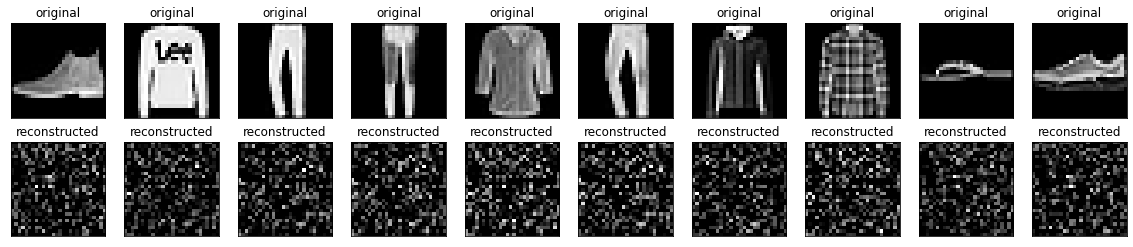

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()